# Covid-19 diagnosis using symptoms

[Prateek Gupta](https://www.pgupta.info) 

2020-05-20

**Abstract:** This notebook is a tutorial on building a typical machine learning classifier. 
The process of doing so spans steps ranging from data wrangling to model selection. 
With the help of each of these steps we hope to make the reader familiar with challenges involved in building a machine learning system. 

# Question

In this hackathon, we want to build a machine learning model to predict COVID-19 infections from symptoms.
It has several applications, for example, triaging patients to be attended to by a doctor or nurse, recommending self-isolation through contact tracing apps. 

Zoabi et al. [[1]](https://www.nature.com/articles/s41746-020-00372-6) builds a decision tree classifier using the publicly available data reported by the Israeli Ministry of Health.
The paper itself dicsusses the various challenges encountered in deploying such a model. 
It is encouraged to read the paper and learn the challeges and ways to overcome them. 

However, in this hackathon, we will use their dataset and make the participant familiar with a typical pipeline of building a machine learning system.

[1] [Zoabi, Y., Deri-Rozov, S. & Shomron, N. Machine learning-based prediction of COVID-19 diagnosis based on symptoms. npj Digit. Med. 4, 3 (2021).]((https://www.nature.com/articles/s41746-020-00372-6))


# Setup the workspace

We will clone their Git repository to to use their dataset

In [181]:
!git clone https://github.com/nshomron/covidpred.git

fatal: destination path 'covidpred' already exists and is not an empty directory.


In [182]:
import pandas as pd
import math
import numpy as np


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Data 

Let's check how the data looks like and how various features are encoded. 

In [183]:
df = pd.read_csv('covidpred/data/corona_tested_individuals_ver_006.english.csv.zip')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [184]:
df['test_date'] = pd.to_datetime(df['test_date'])

Since we do not have any information on what happened to "other" cases, we will exclude them from our exercise. 



In [185]:
df = df[df['corona_result'].isin(['positive', 'negative'])]

##**Split into train/validation/test**



In [186]:
df['cough'].apply(normalise).value_counts()

0.0    233133
1.0     41571
Name: cough, dtype: int64

In [187]:

# Run this on the raw dataframe returned by pd.read_csv, include params for train/test split ratio (default: 80:20 split trainvalid/test & train/valid)
def clean_and_split_data(df, trainvalid_size=0.8):
  df['test_date'] = pd.to_datetime(df['test_date'])
  df = df[df['corona_result'].isin(['positive', 'negative'])]
  
  date_counts = df.groupby(['test_date']).count()['gender'] # take count of any column. They will all be same.
  date_counts = date_counts.sort_index()
  n_obs = df.shape[0]
  cum_counts = date_counts.cumsum()
  cdf = cum_counts / n_obs

  max_training_date = cdf[cdf < trainvalid_size*trainvalid_size].index.max()
  training_data = df[df['test_date'] <= max_training_date]

  min_test_date = cdf[cdf > trainvalid_size].index.min()
  test_data = df[df['test_date'] >= min_test_date]

  valid_data = df[(max_training_date < df['test_date']) & (df['test_date'] < min_test_date)]

  return training_data, valid_data, test_data


In [188]:
train, valid, test = select_and_split_data(df)

In [189]:
training['cough'].value_counts()

0       107926
0        25942
1        23875
1         5776
None       241
Name: cough, dtype: int64

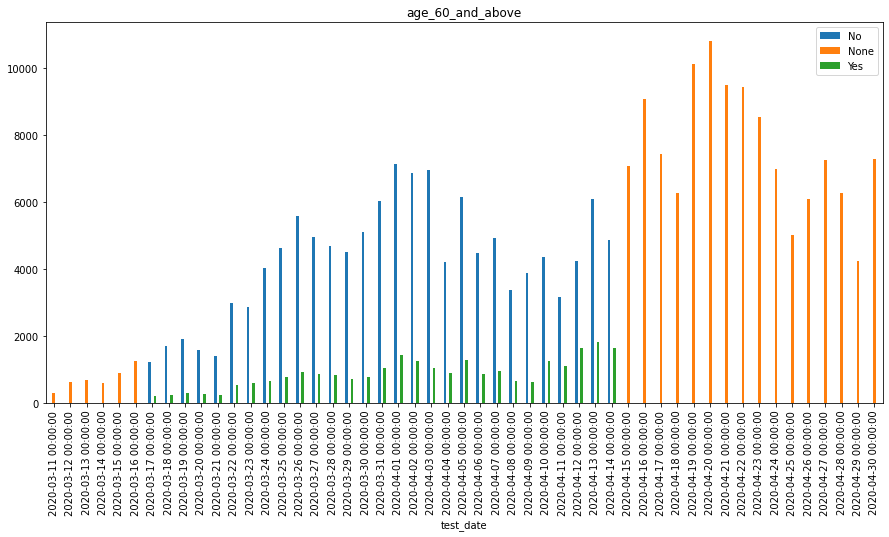

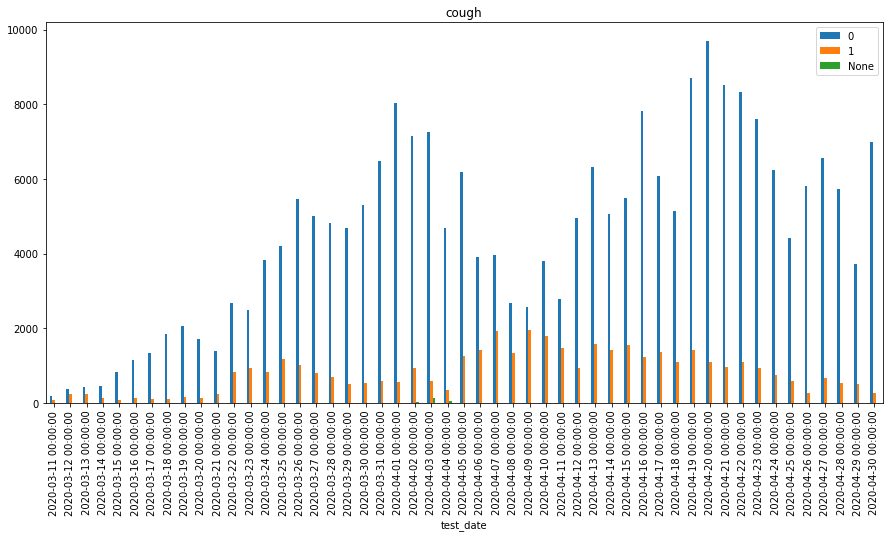

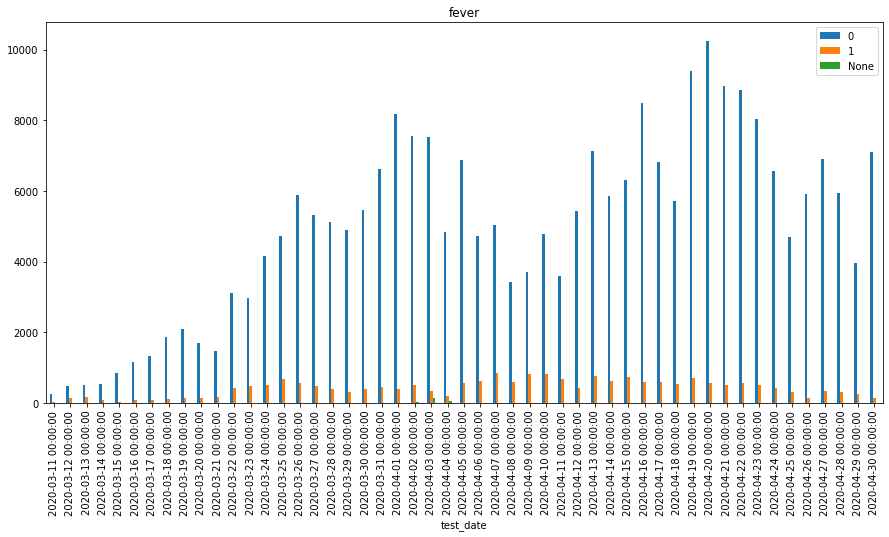

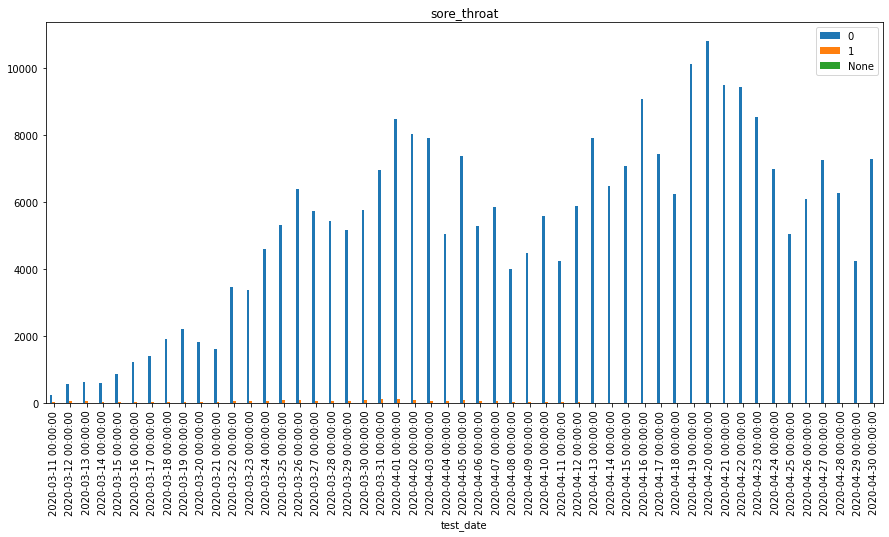

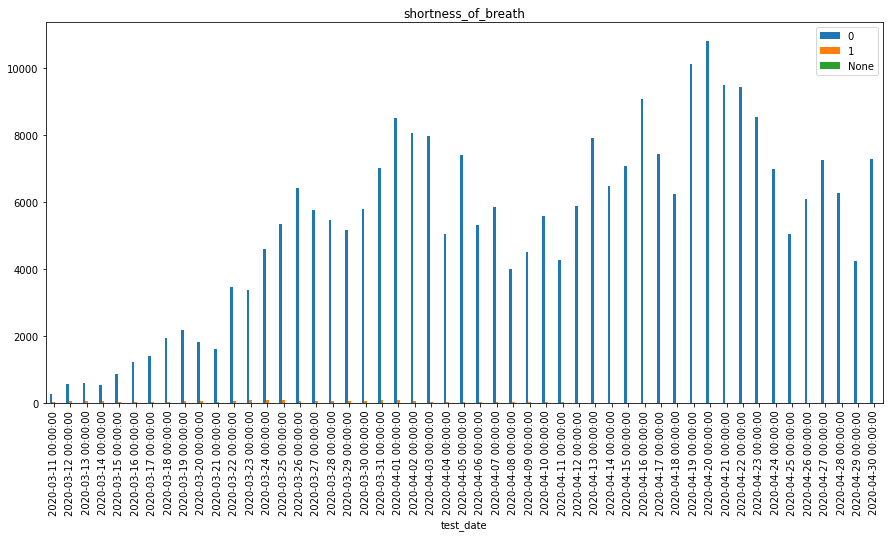

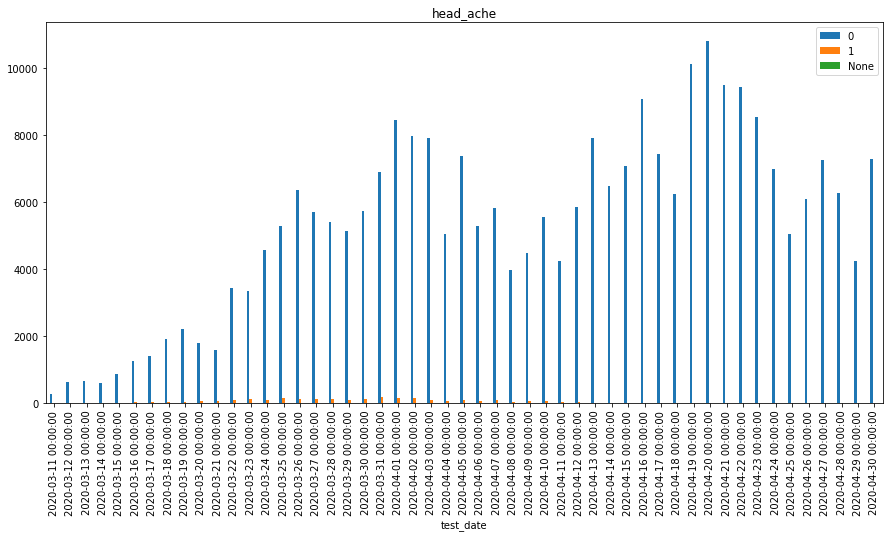

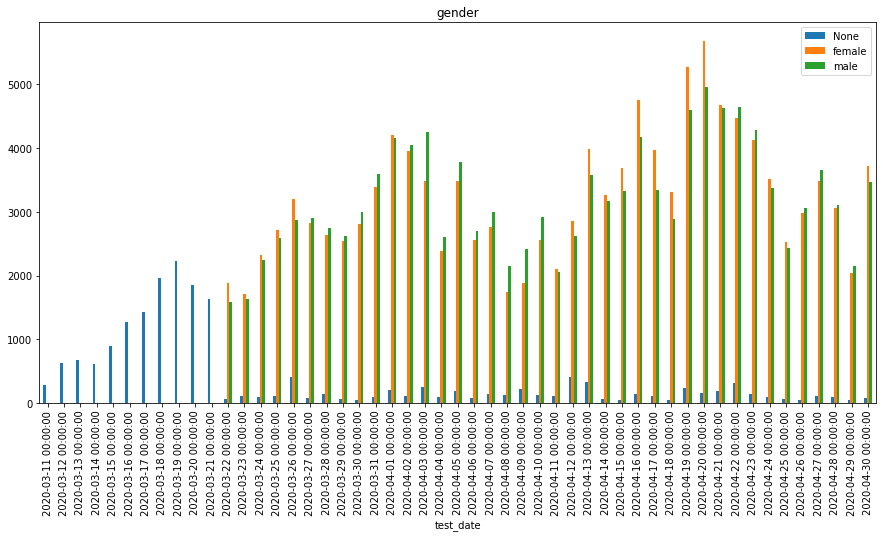

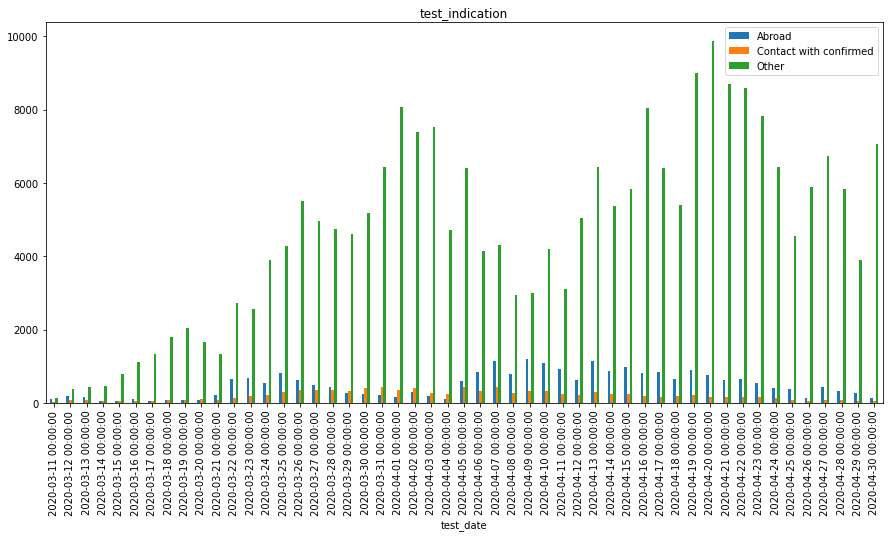

In [211]:
df2 = df.copy()
for col in df2.columns:
  df2.loc[:, col] = df2[col].apply(normalise)

age = df2[['test_date', 'age_60_and_above']]
cough = df2[['test_date', 'cough']]
fever = df2[['test_date', 'fever']]
sorethroat = df2[['test_date', 'sore_throat']]
breath = df2[['test_date', 'shortness_of_breath']]
headache = df2[['test_date', 'head_ache']]
gender = df2[['test_date', 'gender']]
test_indication = df2[['test_date', 'test_indication']]

features = [age, cough, fever, sorethroat, breath, headache, gender, test_indication]


for feature in features:
  tempdf = pd.get_dummies(feature[feature.columns[1]])
  feat = pd.merge(left=feature, right=tempdf,left_index=True, right_index=True)
  feat.drop(feature.columns[1],axis=1,inplace=True)
  feat = feat.groupby('test_date').sum().reset_index()
  feat.set_index("test_date").plot.bar(figsize=(15,7), title=feature.columns[1])


In [210]:
def normalise(x):
  if type(x) == str:
    if x in ['0', '1']:
      return int(x)
    elif x == 'None':
      return 'None'
  return x


# Normalise columns to conver strings to ints and 'None' to np.nan
for col in train.columns:
  train.loc[:, col] = train[col].apply(normalise)
  valid.loc[:, col] = valid[col].apply(normalise)
  test.loc[:, col] = test[col].apply(normalise)


In [192]:
# Drop 'test_date' column and age column (TBC if we want to drop age)
#train.drop(['test_date', 'age_60_and_above'], axis=1,inplace=True)
#valid.drop(['test_date','age_60_and_above'], axis=1,inplace=True)
#test.drop(['test_date','age_60_and_above'], axis=1,inplace=True)
train.drop(['test_date'], axis=1,inplace=True)
valid.drop(['test_date'], axis=1,inplace=True)
test.drop(['test_date'], axis=1,inplace=True)

In [193]:
train['gender'].value_counts(dropna=False)

male      80114
female    79677
NaN        3969
Name: gender, dtype: int64

In [206]:
lb_train = LabelBinarizer()
lb_train.fit(train['corona_result'])

# Train a pipeline to transform categorical variables with imputation of missing values
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('encoder', OneHotEncoder(handle_unknown='error', drop='first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, [0])
    ])

preprocessor.fit(train.drop('corona_result',axis=1))

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('cat',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='most_frequent',
                                                                verbose=0)),
                                                 ('encoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
               

In [195]:
#X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.2, random_state=42, stratify=y_rem)

# Feature Engineering

In this section, we will transform the features that models can operate upon. Note that this transformation doesn't have to be unique. 
It is very much dependent on the type of model you are building. 

Here is the list of questions to guide your feature engineering task 

1.   How will you represent the features in numerical format that can be accessible by model? 
2.   Are there any redundancies in your feature representation?
3.   How will you represent targets in a format accessible to the model?

Check out [`sklearn`'s preprocessing library](https://scikit-learn.org/stable/modules/preprocessing.html) for easy-to-use functions to do this. 

In [196]:
def preprocess(data, encoder, lb):
  """
  Transforms `data` into format required for model building

  Args:
    data (pd.DataFrame): dataframe with columns `INPUT_FEAUTURES` and `TARGET_COLUMN`
    encoder (sklearn.preprocessing.OneHotEncoder): A fitted OneHotEncoder to be used to transform `INPUT_FEATURES`
    lb (sklearn.preprocessing.LabelBinarizer): A fitted LabelBinarizer to be used to transform `TARGET_COLUMN`
  
  Returns:
    model_input (np.array): each row is an observation, columns are one-hot encoded features of `INPUT_FEATURES`
    model_target (np.array): 1D array with 1 where `TARGET_COLUMN` is "positive" and 0 otherwise.
  """

  model_target = lb.transform(data['corona_result']).flatten()
  model_input = encoder.transform(data.drop('corona_result', axis=1))

  return model_input, model_target

In [197]:
train['gender'].value_counts(dropna=False)

male      80114
female    79677
NaN        3969
Name: gender, dtype: int64

In [198]:
X_train, y_train = preprocess(train, preprocessor, lb_train)
X_valid, y_valid = preprocess(valid, preprocessor, lb_train)
X_test, y_test = preprocess(test, preprocessor, lb_train)

In [199]:
X_valid, y_valid = preprocess(valid, preprocessor, lb_train)
X_test, y_test = preprocess(test, preprocessor, lb_train)

# Model building

In this section, we will build various classifiers using `sklearn`. You do not have to restrict yourself to `sklearn`. Please feel free to use any other library.

**TRY:**  Try various classifiers that you have learned so far.
Here is the list of models to try :

*  Logistic Regssion: [User Guide](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression). [API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
*   Decision Trees: [User Guide](https://scikit-learn.org/stable/modules/tree.html#classification). [API](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). You can head down in the User Guide to [other Tree algorithms](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) if you fancy. 
*   Categorical Naive Bayes.[User Guide](https://scikit-learn.org/stable/modules/naive_bayes.html#categorical-naive-bayes). [API](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html#sklearn.naive_bayes.CategoricalNB)
*   Linear Discriminant Analysis. [User Guide](https://scikit-learn.org/stable/modules/lda_qda.html#). [API](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis)
*   Quadratic Discriminant Analysis. [User Guide](https://scikit-learn.org/stable/modules/lda_qda.html#). [API](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis)
*   Support Vector Machines. [User Guide](https://scikit-learn.org/stable/modules/svm.html#classification). [API](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
*   Nearest neighbors classification. [User Guide](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification). [API](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
*   Neural networks - Multi-layer Perceptron (MLP). [User Guide](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#multi-layer-perceptron). [API](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)



In [200]:
from sklearn import tree

AUC ROC score for the model: 0.6279812553555141 



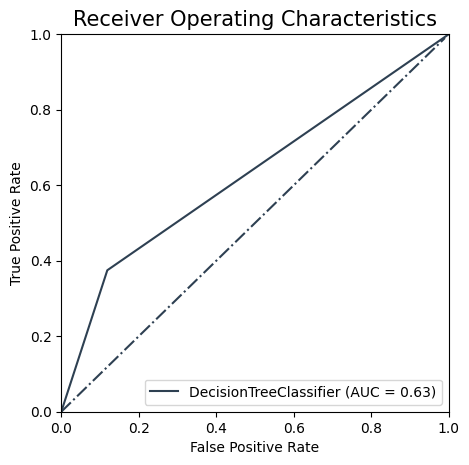

In [201]:
model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)
y_score = model.predict_proba(X_valid) # (n_samples, n_clases) with each value being the probability of being in that class

print("AUC ROC score for the model:", roc_auc_score(y_true = y_valid, y_score= y_score[:, 1]), "\n")

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)
plot_roc_curve(model, X_valid, y_valid, ax =ax, color="#2E4052")

# formatting 
ax.plot(np.arange(0,1, 0.01), np.arange(0, 1, 0.01), color="#2E4052", linestyle="-.") # reference line
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
_ = ax.set_title("Receiver Operating Characteristics", fontsize=15)

In [202]:
y_fake = np.zeros(y_score.shape)
y_fake

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

# Evaluate Model

In this section, we will evaluate our model's performance on the validation dataset. 

Here are the list of questions to think about while deciding how to evaluate your model - 
*   Is accuracy the right metric to evaluate the model? Are inaccuracies correctly penalized in the accuracy metric?
*  Would you think that the cost of false negative is more than the false positive? Is it dependent on the application?
*  Which metric will minimize false negatives and false positives?
*   Which dataset should you chose to evaluate the model? Validation or Test?
What other metric is relevant in our context?  

For benchmarking everyone’s results we will stick to ROC AUC score as a metric. 
There are standard functions to compute these scores in `sklearn`, so we will use them. 
Specifically, we will be using [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) and [`plot_roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html).


In [203]:
def evaluate(model, X, Y):
  """
  Returns the AUC-ROC for `model` as evaluated on (X, Y)

  Args:
    model (): Any model that has a function predict_proba and returns probability for each row in `X`.
    X (np.array): Input to the model containing feature values
    Y (np.array): 1D array containing true class i.e. 0 or 1
  
  Returns:
    (float): AUC ROC for the model
  """

  # For example - 
  # y_score = model.predict_proba(X) # (n_samples, n_clases) with each value being the probability of being in that class
  # return roc_auc_score(y_true=Y, y_score=y_score[:, 1])

# Hyperparameter Search

In this section we will be searching for the best parameters to build our models. 
This is where we will use our validation dataset. 




Hyperparameter search can become messy if you have lots of paramters. 
A brute force method to do such a search will be to do a grid search to fit tons of models. 
Thus, a smarter way to do hyperparameter search has been the subject of research. 

**TRY:** If interested, read [here](https://scikit-learn.org/stable/modules/grid_search.html) for more details and incorporate some of those ideas in the model building process. 

# Report your results

**NOTE:** You should use the test dataset only when you are done with hyperparameter search on your model. 
This is because the test dataset is not involved in the model building process, thereby making sure that the performance evaluation on the test dataset measures how well the proposed model is able to generalize.

In [204]:
X_test, Y_test = preprocess(test_data, encoder, lb)
auc_score = evaluate(best_model, X_test, Y_test)
print(f"AUC-ROC on the test dataset:{auc_score}")


NameError: ignored

Is this the end?

What do you need to do to make the model practically applicable? How would you use this model in the real life?

# Collaborate with Ensemble 

You can combine various models to form an ensemble model. 
There are various ways to combine these models. 
All of them serve a particular purpose (e.g. reducing variance, increasing accuracy. etc.). 

The simplest example of an ensemble is to combine the constituent models via voting. This can be done in two ways:
*  soft voting - likelihood of the input belonging to a class is the mean of the likelihood predicted by the constituent models, 
*  hard-voting - likelihood of the input belonging to a class is determined by frequency of the constutuent models predicting that class for the input.

Thus, if you are working in a team, let each member try out different models. At the end, combine your models and make an ensemble model. 

Here is the [User Guide](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier) and [API](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) for making such an ensemble model.

# Extras: Class imbalance

**TRY:** 
 Why not try resampling techniques to optimize for ROC AUC?





# Extras: Dimensionality Reduction

**TRY:** You can try dimensionality reduction from 16 dimensions to just 2 dimensions and visualize 2D plot with just two categories - "positive" and "negative". 
To do this, try various dimension reduction techniques, for example, [LDA](https://scikit-learn.org/stable/modules/lda_qda.html#mathematical-formulation-of-lda-dimensionality-reduction), [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA), [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). 


# Poster template 

It is often the most difficult task to communicate the project's finding concisely in 1 minute or in a 1 slide. 
Therefore, our suggestion will be to touch upon the following points in your poster -  

1. Briefly define the problem
2. Briefly describe the dataset 
3. What did you learn about various models/techniques/etc.? e.g. 
4. What's the auc score of your final model did you get?

If you want to learn what matters in building such posters, check out this great [YouTube video](https://www.youtube.com/watch?v=1RwJbhkCA58).
Specifically, we should try and avoid posters with a lot of stuff to avoid cognitive overload. 
The templates suggested in the video can be found [here](https://osf.io/ef53g/). 
Note these are for academic papers, however, you can follow a similar ideology to concizsely display your work. 